In [306]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('mode.chained_assignment', None)

# Data Loading and Preprocessing

## Compiling data

In [307]:
opened = pd.read_csv('email_opened_table.csv')
email_table = pd.read_csv('email_table.csv')
clicked = pd.read_csv('link_clicked_table.csv')

In [308]:
opened_email_id = opened['email_id'].to_list()
clicked_email_id = clicked['email_id'].to_list()

In [309]:
email_table['opened'] = email_table['email_id'].apply(lambda x: 1 if x in opened_email_id else 0)
email_table['clicked'] = email_table['email_id'].apply(lambda x: 1 if x in clicked_email_id else 0)

## Sample Distriution Checking

Before perform any statistical analysis, it is critical to check the balance of the sample to prevent from wrong conclusion

**As shown in the bar charts below, across different features, the sampling is fairly even.**

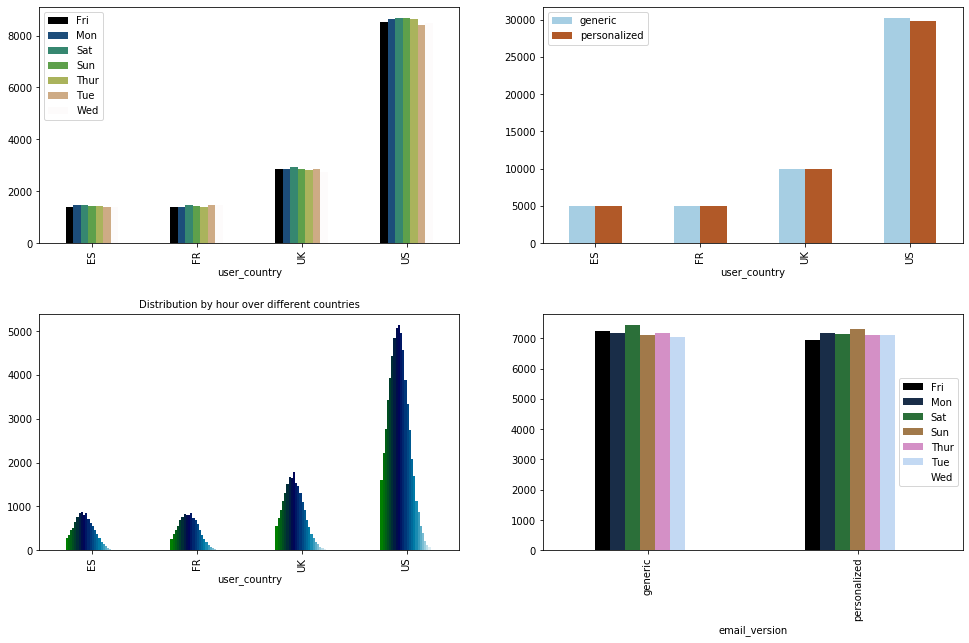

In [310]:
country_weekday = email_table.pivot_table(index='user_country', columns='weekday', aggfunc={"email_id": 'count'})
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
country_weekday.plot(kind='bar', ax=ax[0,0], colormap='gist_earth')
ax[0,0].legend(labels=['Fri','Mon','Sat','Sun','Thur','Tue','Wed'])

country_email_version = email_table.pivot_table(index='user_country', columns='email_version', aggfunc={"email_id": 'count'})
country_email_version.plot(kind='bar', ax=ax[0,1], colormap='Paired')
ax[0,1].legend(labels=['generic', 'personalized'])

country_hour = email_table.pivot_table(index='user_country', columns='hour', aggfunc={"email_id": 'count'})
country_hour.plot(kind='bar', ax=ax[1,0], colormap='ocean', legend=False)
ax[1,0].set_title('Distribution by hour over different countries', fontsize=10)

weekday_email_version = email_table.pivot_table(index='email_version', columns='weekday', aggfunc={"email_id": 'count'})
weekday_email_version.plot(kind='bar', ax=ax[1,1], colormap='cubehelix')
ax[1,1].legend(labels=['Fri','Mon','Sat','Sun','Thur','Tue','Wed'], loc='right')

plt.subplots_adjust(hspace=0.3, right=0.98);

# Analysis

## Question one

**Overall, only 10% of users had opened the email and only 2% of them clicked on the link within the email. However, among those who opened the email, 20% of them had actually clicked on the link.**

In [311]:
opened_ratio = email_table.groupby('opened').agg({"email_id": len})
opened_ratio['opened_ratio'] = opened_ratio['email_id'].apply(lambda x: x/opened_ratio['email_id'].sum())
opened_ratio[['opened_ratio']]

,opened_ratio
opened,
0,0.89655
1,0.10345


In [312]:
clicked_ratio = email_table.groupby('clicked').agg({"email_id": len})
clicked_ratio['clicked_ratio'] = clicked_ratio['email_id'].apply(lambda x: x/clicked_ratio['email_id'].sum())
clicked_ratio[['clicked_ratio']]

,clicked_ratio
clicked,
0,0.97881
1,0.02119


In [313]:
opened_clicked = email_table[email_table.opened==1]
opened_clicked_ratio = opened_clicked.groupby('clicked').agg({"email_id": len})
opened_clicked_ratio['clicked_ratio'] = opened_clicked_ratio['email_id'].apply(lambda x: x/opened_clicked_ratio['email_id'].sum())
opened_clicked_ratio[['clicked_ratio']]

,clicked_ratio
clicked,
0,0.8
1,0.2


## Question two

**US and UK users have significant higher clicked ratio than Spain or France. It might because the email language is in English.**

In [314]:
country = email_table.groupby('user_country').agg({"email_id": 'count',"clicked": sum})
country['clicked_ratio'] = country['clicked']/country['email_id']
country[['clicked_ratio']]

,clicked_ratio
user_country,
ES,0.008327
FR,0.008004
UK,0.024675
US,0.024360


**People might prefer short email over the long one.**

In [315]:
text = email_table.groupby('email_text').agg({"email_id": 'count',"clicked": sum})
text['clicked_ratio'] = text['clicked']/text['email_id']
text[['clicked_ratio']]

,clicked_ratio
email_text,
long_email,0.018538
short_email,0.023872


**People seemed to like personized emails more.**

In [316]:
version = email_table.groupby('email_version').agg({"email_id": 'count',"clicked": sum})
version['clicked_ratio'] = version['clicked']/version['email_id']
version[['clicked_ratio']]

,clicked_ratio
email_version,
generic,0.015137
personalized,0.027294


**Weekdays except for Friday might be better timing for sending out emails.**

In [317]:
weekday = email_table.groupby('weekday').agg({"email_id": 'count',"clicked": sum})
weekday['clicked_ratio'] = weekday['clicked']/weekday['email_id']
weekday[['clicked_ratio']]

,clicked_ratio
weekday,
Friday,0.014037
Monday,0.022906
Saturday,0.017846
Sunday,0.016751
Thursday,0.024445
Tuesday,0.024889
Wednesday,0.027620


**Midnight seemed to be popular.**

In [318]:
hour = email_table.groupby('hour').agg({"email_id": 'count',"clicked": sum})
hour['clicked_ratio'] = hour['clicked']/hour['email_id']
hour[['clicked_ratio']].sort_values('clicked_ratio', ascending=False)

,clicked_ratio
hour,
23,0.041379
24,0.028986
10,0.028240
11,0.027128
9,0.025794
12,0.025661
15,0.024907
16,0.023197
14,0.020742


**Just by looking at click rate by different attributes, we can see that the click rate for the population might be different, hence, makes it silly to randomize the sample set. However, it is not statistically rigorous, hypothesis tests will be conducted to help verify the truth.**

Since some variables have more than two values, we therefore only test for the highest and the lowest value.

In [319]:
import statsmodels.stats.proportion as sp

def hypothesis_testing(data):
    
    data = data.sort_values('clicked_ratio').iloc[[0,-1],:]
    p1, p2 = data.iloc[0,1], data.iloc[1,1]
    n1, n2 = data.iloc[0,0], data.iloc[1,0]
    z_score, p_value = sp.proportions_ztest([p1, p2], [n1, n2], alternative='smaller')

    print("Null hypothesis: group1 mean click rate is higher than group2", '\nZ statistics:', z_score, 
          '\nP value:', p_value, 
          "\nReject null hypothesis at 5% significance: ", p_value <= 0.05) 


In [320]:
hypothesis_testing(country)

Null hypothesis: group1 mean click rate is higher than group2 
Z statistics: -9.935803459601559 
P value: 1.4541093504819594e-23 
Reject null hypothesis at 5% significance:  True


In [321]:
hypothesis_testing(text)

Null hypothesis: group1 mean click rate is higher than group2 
Z statistics: -5.856118747168301 
P value: 2.369047487976893e-09 
Reject null hypothesis at 5% significance:  True


In [322]:
hypothesis_testing(version)

Null hypothesis: group1 mean click rate is higher than group2 
Z statistics: -13.347220627379018 
P value: 6.147566085595621e-41 
Reject null hypothesis at 5% significance:  True


In [323]:
hypothesis_testing(weekday)

Null hypothesis: group1 mean click rate is higher than group2 
Z statistics: -7.9989581321333265 
P value: 6.273818531706112e-16 
Reject null hypothesis at 5% significance:  True


In [324]:
hypothesis_testing(hour)

Null hypothesis: group1 mean click rate is higher than group2 
Z statistics: -2.565616014910713 
P value: 0.005149638637904811 
Reject null hypothesis at 5% significance:  True


**It turned out that there were some groups had significant higher click rate, therefore, the VP of marketing might not be wrong, it makes sense to concentrate on some segments in order to get the emails clicked.**

To explore which segments potentially have the highest click rate, we can try different permutations of the features.  First step, all numeric features should be categorized. Some features that have a large range of value, for instance, "hour" should as well be re-categorized to prevent sampling from being too small.

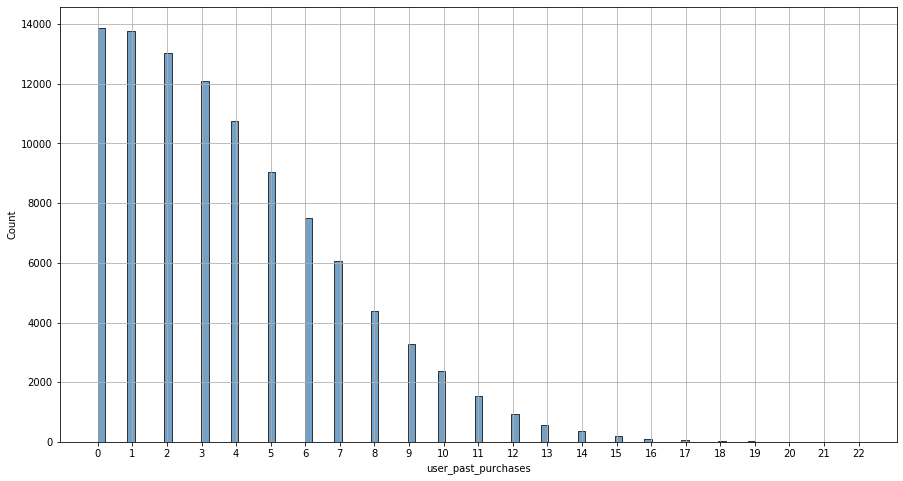

In [325]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.histplot(email_table['user_past_purchases'], ax=ax, color='steelblue')
ax.grid(True)
ax.set_xticks(range(max(email_table['user_past_purchases'])+1));

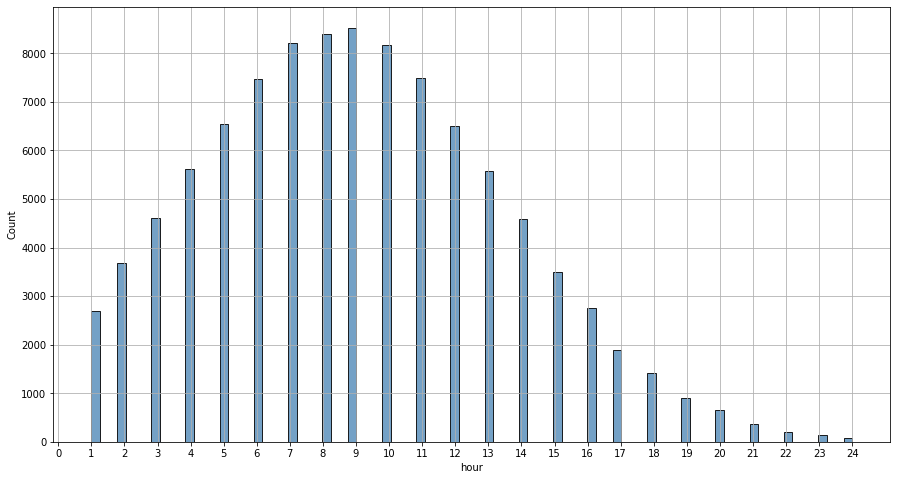

In [326]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.histplot(email_table['hour'], ax=ax, color='steelblue')
ax.grid(True)
ax.set_xticks(range(max(email_table['hour'])+1));

In [339]:
def categorize_past_purchases(x):
    
    if x >= 6:
        frequency =  "High_Frequency"
    elif x >= 3:
        frequency =  "Medium_Frequency"
    elif x >= 1:
        frequency =  "Low_Frequency"
    else:
        frequency =  "No_Purchase"
    return frequency


In [340]:
def categorize_hour(x):
    
    if x <= 3:
        name =  "Midnight"
    elif x <= 7:
        name =  "Dawn"
    elif x <= 11:
        name =  "Morning"
    elif x <= 15:
        name =  "Afternoon"
    elif x <= 19:
        name = "Twilight"
    else:
        name =  "Evening"
    return name


In [341]:
email_table['purchase_frequency'] = email_table['user_past_purchases'].apply(categorize_past_purchases)
email_table['hour_discrete'] = email_table['hour'].apply(categorize_hour)
email_table['weekday_group'] = email_table['weekday'].apply(lambda x: "weekend" if x in ['Saturday', 'Sunday'] else "weekday")

**Clearly short and personalized emails were more popular, therefore, it makes sense to start from this segment when seeking for high click rate groups. Filtering out those smaller segments in terms group size is also important as they do not show strong evidence due to the small sample size, we would like to use 30 as a threshold because it is considered a large enough sample in statistics.**

In [342]:
email_table_filter = email_table[(email_table.email_text=='short_email')&(email_table.email_version=='personalized')]

In [343]:
emails_sent = email_table_filter.pivot_table(columns=['hour_discrete','weekday_group'],index =["purchase_frequency", "user_country"], 
                                     values="clicked", aggfunc='count')
emails_clicked = email_table_filter.pivot_table(columns=['hour_discrete','weekday_group'], index=["purchase_frequency", "user_country"], 
                                     values="clicked", aggfunc='sum')

emails_sent = emails_sent[emails_sent>=30]
emails_clicked = emails_clicked[emails_sent>=30]
emails_ratio = emails_clicked/emails_sent

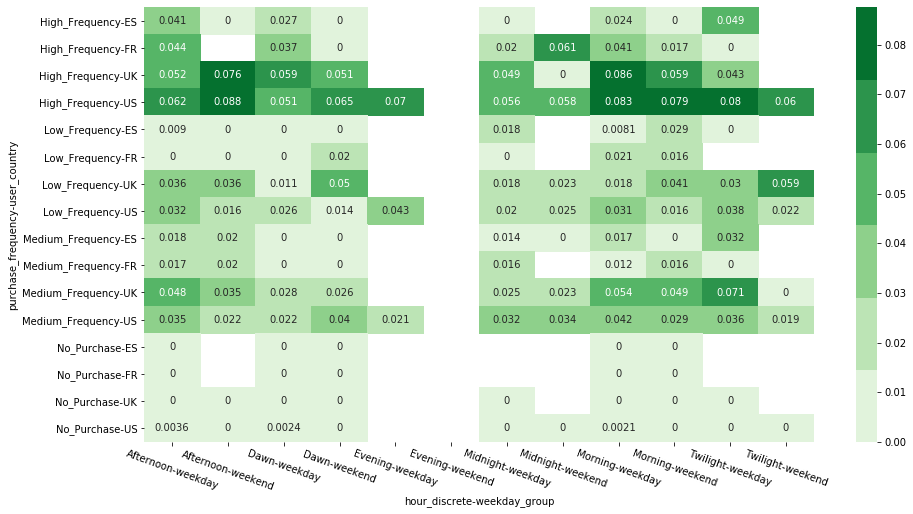

In [344]:
fig, ax = plt.subplots(figsize=(15, 8))
colormap = sns.color_palette("Greens")
sns.heatmap(emails_ratio, annot=True, cmap=colormap)
plt.xticks(rotation=-20);

**To optimize the click through rate (CTR), the marketing team should focus on users who purchased before, the more the better. US and UK are the main markets to penetrate, however, as aforementioned, it might due to the language issue so Spain and France had such low CTR. In terms of timing, dawn(4:00-7:00) and morning(8:00-11:00) on weekdays turned out to be the most effective. In a nutshell, short personalized emails scheduled to send out in early day on weekdays to frequent purchased users from US or UK would probably yield the optimized CTR.**

## Question three

To estimate the potential improvement on CTR, we can compare the CTR of group of interest with the rest.

In [345]:
target_features = ['email_text','email_version','user_country','hour_discrete','purchase_frequency','weekday_group']
email_table['key'] = email_table[target_features].apply(lambda x: '_'.join(x), axis=1)

In [347]:
target = ['short_email_personalized_US_Morning_High_Frequency_weekday', 'short_email_personalized_UK_Morning_High_Frequency_weekday',
    'short_email_personalized_US_Morning_Medium_Frequency_weekday', 'short_email_personalized_UK_Morning_Medium_Frequency_weekday',
    'short_email_personalized_US_Dawn_High_Frequency_weekday', 'short_email_personalized_UK_Dawn_High_Frequency_weekday',
    'short_email_personalized_US_Dawn_Medium_Frequency_weekday', 'short_email_personalized_UK_Dawn_Medium_Frequency_weekday']

In [349]:
email_table['group'] = email_table['key'].apply(lambda x: "test" if x in target else "control")

In [359]:
optimum = email_table.groupby('group').agg({"email_id": 'count', "clicked": sum})
optimum['clicked_ratio'] = optimum['clicked']/optimum['email_id']
optimum

,email_id,clicked,clicked_ratio
group,,,
control,94844,1858,0.019590
test,5156,261,0.050621


In [358]:
hypothesis_testing(optimum)

Null hypothesis: group1 mean click rate is higher than group2 
Z statistics: -15.067336788697922 
P value: 1.3280286951594557e-51 
Reject null hypothesis at 5% significance:  True


In [363]:
optimum_ratio = 0.050621
overall_ratio = (1858+261)/(94844+5156)
improvement = (optimum_ratio-overall_ratio)/overall_ratio

In [375]:
print("Potential CTR: ", optimum_ratio)
print("============================")
print("Sample Overall CTR: ", overall_ratio)
print("============================")
print(f"Potential Improvement: {round(improvement*100, 2)}%", )

Potential CTR:  0.050621
Sample Overall CTR:  0.02119
Potential Improvement: 138.89%


**Although the potential CTR is statistically sigficant higher than the sample CTR in this data set. However, it might be biased based on the samping method, a more rigorous and strict A/B testing needs to be conducted to be fully confident that this model outputs a better result.** 

# Conclusion

- **The variable that impacts CTR was the number past purchases.**
- **There were about 14% of emails were sent to users who had never made any purchase and barely got clicked, the marketing team should find a way that attracts new customers or send them emails that are more ralated.**
- **The number of emails sent out in evenings (20:00-23:59) was small, however, based on the observation, midnight (24:00-03:59) was a good timing for marketing, increase the volume of emails in this period might be effective.**